# Case Study: ISLAS flight IS22-07, 29th. March 2022



In [1]:
# imports from packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
import matplotlib.dates as mdates
from matplotlib.lines import Line2D  # for legend handle
#import seaborn as sns
#from global_land_mask import globe # for checking if on land
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from datetime import datetime

# imports from files
import functions
import read_cdp
import read_cip_txt
#import read_lwc
import read_nav
import read_cip_nc
import plots
import numb_conc
#import in_cloud_detect
#from data_intake import read_sic
#from plots import plots.letter_annotation
from plots import plot_map

# surpress UserWarning connected to timezoneless np.datetime
warnings.filterwarnings("ignore", message="no explicit representation of timezones available for np.datetime64")
# surpress UserWrning connected to boolean series indexing (creating dataframe with null values)
warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index.")

In [30]:
# --- Global formatting/settings/variables

flight = 'IS22-07'

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# colors for flights (to use all the same colors!
c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:green',
              'IS22-03':'tab:red',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:blue',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:gray',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:cyan',
              'IS22-10':'tab:pink',
              'IS22-11':'tab:orange'}

# Threshold for in-cloud values
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

In [31]:
# --- Data import
# Based on scripts in files read_*.py

# Navigational data (nav_df: data variables, nav_stats_dict: statistics for each flight)
nav_df, nav_stats_dict = read_nav.read_nav()

# CDP data (cdp_bulk_df: Bulk variables per flight, cdp_bins_df: Bin details (max, min size)
#           cdp_var_df: Variable information (names, units), cdp_meta_df: Metadata/instrument settings)
cdp_bulk_df, cdp_bins_df, cdp_var_df, cdp_meta_df = read_cdp.read_cdp(nav_df)

# CIP data 
# nc file(bulk information) (cip_bulk_calc_df: Bulk variables per flight, cip_conc_df: Concentration per bin, 
#                            cip_varnc_df: Variable, longname and unit)
cip_bulk_calc_df, cip_conc_df, cip_varnc_df = read_cip_nc.read_cip_nc() 
cip_pb_df, cip_bins_df, cip_var_df, cip_proc_df = read_cip_txt.read_cip_txt()

----Reading CDP files:
Reading: ../2022-islas/as220014/microphy/pads/20220403071511/02CDP 20220403071511.csv
Reading: ../2022-islas/as220009/microphy/pads/20220326080106/02CDP 20220326080106.csv
Reading: ../2022-islas/as220010/microphy/pads/02CDP 20220326133751.csv
Reading: ../2022-islas/as220007/microphy/pads/20220324080247/02CDP 20220322105458.csv
Reading: ../2022-islas/as220015/microphy/pads/20220403123534/02CDP 20220403123534.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324080247/02CDP 20220324080247.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324113123/02CDP 20220324113123.csv
Reading: ../2022-islas/as220008/microphy/pads/20220324130909/02CDP 20220324130909.csv
Reading: ../2022-islas/as220013/microphy/pads/20220331093304/02CDP 20220331093304.csv
Reading: ../2022-islas/as220011/microphy/pads/02CDP 20220329081432.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330135853/02CDP 20220330135853.csv
Reading: ../2022-islas/as220012/microphy/pads/20220330134834/

In [32]:
nav_stats_dict

,safireid,takeoff,landing,flightid,time_in_air
0,as220007,2022-03-22 10:55:08,2022-03-22 15:01:25,IS22-02,4:06:17
1,as220008,2022-03-24 08:03:05,2022-03-24 12:01:01.175935,IS22-03,3:57:56.175935
2,as220008,2022-03-24 13:09:26.702131,2022-03-24 17:02:39,IS22-04,3:53:12.297869
3,as220009,2022-03-26 08:10:09,2022-03-26 12:33:00,IS22-05,4:22:51
4,as220010,2022-03-26 13:38:02,2022-03-26 17:39:37,IS22-06,4:01:35
5,as220011,2022-03-29 08:18:12,2022-03-29 12:25:46,IS22-07,4:07:34
6,as220012,2022-03-30 13:58:02,2022-03-30 17:04:29,IS22-08,3:06:27
7,as220013,2022-03-31 09:32:56,2022-03-31 13:17:03,IS22-09,3:44:07
8,as220014,2022-04-03 07:14:29,2022-04-03 11:02:52,IS22-10,3:48:23
9,as220015,2022-04-03 12:34:45,2022-04-03 16:38:51,IS22-11,4:04:06


In [33]:
cip_bins_df

,Bin startpoints (microns),Bin midpoints (microns):,Bin endpoints (microns):,Bin_name
0,12.5,25.0,37.5,Conc001
1,37.5,50.0,62.5,Conc002
2,62.5,75.0,87.5,Conc003
3,87.5,100.0,112.5,Conc004
4,112.5,125.0,137.5,Conc005
...,...,...,...,...
59,1487.5,1500.0,1512.5,Conc060
60,1512.5,1525.0,1537.5,Conc061
61,1537.5,1550.0,1562.5,Conc062
62,1562.5,1575.0,1587.5,Conc063


In [34]:
# -- Prepare dataframe for calculations
# Join the relevant columns from the nav, the cip, and the cdp data
# CIP IWC, LWC etc have been calculated for particles >100 mum
cip_df = cip_bulk_calc_df[['time', 'NT (#/m3)','IWC (gram/m3)','LWC (gram/m3)', 'MVD (um)']].sort_values(by='time', axis=0)
cdp_df = cdp_bulk_df[['time', 'Number Conc corr (#/cm^3)', 'LWC corr (g/m^3)','MVD (um)','Number Conc (#/cm^3)', 'LWC (g/m^3)']].sort_values(by='time', axis=0)

# rename columns to identify instrument and standardize units
cip_df = cip_df.rename(columns={'NT (#/m3)':'cip NumConc (#/m^3)','IWC (gram/m3)':'cip IWC (g/m^3)','LWC (gram/m3)':'cip LWC (g/m^3)', 'MVD (um)':'cip MVD (um)'})
cdp_df = cdp_df.rename(columns={'Number Conc corr (#/cm^3)': 'cdp NumConc corr (#/cm^3)', 'LWC corr (g/m^3)':'cdp LWC corr (g/m^3)',
                                'MVD (um)': 'cdp MVD (um)','Number Conc (#/cm^3)': 'cdp NumConc (#/cm^3)', 'LWC (g/m^3)':'cdp LWC (g/m^3)'})

# select temperature and flightid from nav
nav_sel_df = nav_df[['Latitude (degree)', 'Longitude (degree)','Altitude (meter)','Temperature (Celsius)','TAS (m/s)','flightid', 'safireid']].sort_values(by='time', axis=0)

# join cip and cdp by time
meas_df = pd.merge_asof(cip_df, cdp_df, on = 'time', direction = 'nearest', suffixes=('_cip','_cdp'))
microphy_df = pd.merge_asof(meas_df, nav_sel_df, on = 'time', direction = 'nearest')

# add manually set selection categories
microphy_df = functions.add_man_relevance(microphy_df) # relevant clouds: lower mixed phase
microphy_df = functions.add_man_cloud(microphy_df)     # cloudid: individual flight patterns from single flights

# prepare dataframe for later calculation of position in cloud and surface conditions:
microphy_df['Cloud_pos']=np.nan # empty column to be filled with cloud positions
microphy_df['Cloud_rel_alt']=np.nan # empty column to be filled with cloud relative altitude (0 = base 1 = top)
microphy_df['surface_cond']='sea-ocean' # set default to sea-ocean

# rearrange columns more logically: - Positional - Identifier - Ambient - Microphysical - Calculated
microphy_df = microphy_df[['time','Latitude (degree)','Longitude (degree)','Altitude (meter)',
                          'flightid', 'safireid',
                          'Temperature (Celsius)','TAS (m/s)',
                           'cip NumConc (#/m^3)','cdp NumConc (#/cm^3)','cdp NumConc corr (#/cm^3)',
                           'cip IWC (g/m^3)','cip LWC (g/m^3)','cdp LWC (g/m^3)','cdp LWC corr (g/m^3)',
                           'cip MVD (um)','cdp MVD (um)',
                           'Relevance','cloudid','Cloud_pos', 'Cloud_rel_alt', 'surface_cond']]


In [35]:
cip_bulk_calc_df.columns

Index(['time', 'UTC Seconds', 'TAS (m/s)', 'MVD (um)', 'LWC (gram/m3)',
       'NT (#/m3)', 'MND (um)', 'Area Ratio (1/m)', 'IWC (gram/m3)',
       'safireid'],
      dtype='object')

In [36]:
# --- calculated parameters

# Total number concentration (adding CIP and CDP)
microphy_df['cip NumConc (#/cm^3)'] = microphy_df['cip NumConc (#/m^3)']*10**(-6) # adjust cip to equal units as cdp
# sum cip and cdp in #/cm3 to find total num conc
microphy_df['tot NumConc (#/cm3)'] = microphy_df['cip NumConc (#/cm^3)']+microphy_df['cdp NumConc corr (#/cm^3)']

# TWC - Total Water Content: estimate total water content from cdp LWC and CIP IWC 
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)'] + microphy_df['cip IWC (g/m^3)']

# Selection of in-cloud values (True or False based on threshold condition)
in_cl_th = 0.01 # in-cloud threshold based on Korolev 2003
microphy_df['incloud']= microphy_df['TWC (gram/m3)']>in_cl_th #direct boolean indexing (True if bigger, False if smaller)

# -- incloud height calculations
# calculating in-cloud altitude dictionary for all named clouds:
cloud_alt_dict = functions.cloud_alt_pos(microphy_df, 'cloudid') # get the cloud top and base heights (in a dict)

# Calculating in-cloud relative altitude based on max and min altitude of cloud
cloudids = microphy_df[microphy_df['cloudid']!='nan']['cloudid'].unique() # get unique cloudids
microphy_df['Cloud_rel_alt']=microphy_df.apply(functions.rel_alt, args=(cloudids, cloud_alt_dict), axis=1)

# set category "Top-Bulk-Base", categorize data based on where in cloud:
# Apply the function row-wise to create the new column
microphy_df['Cloud_pos'] = microphy_df.apply(functions.set_c_pos_cat, cloud_pos_dict = cloud_alt_dict, axis=1)

In [37]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cip MVD (um)',
       'cdp MVD (um)', 'Relevance', 'cloudid', 'Cloud_pos', 'Cloud_rel_alt',
       'surface_cond', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud'],
      dtype='object')

In [38]:
# -- Calculate SLF (supercooled liquid fraction)
# estimate total water content from cdp as liquid and all from CIP as ice (use LWC from cdp and IWC from CIP)
microphy_df['TWC (gram/m3)'] = microphy_df['cdp LWC corr (g/m^3)']+microphy_df['cip IWC (g/m^3)']

# masking all values of TWC lower than in cloud threshold
microphy_df['TWC (gram/m3)'] = microphy_df['TWC (gram/m3)'].mask(microphy_df['TWC (gram/m3)'] < lwc_th)

# also mask cloud parameters for same time step
microphy_df['cdp LWC corr (g/m^3)'] = microphy_df['cdp LWC corr (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['cip IWC (g/m^3)'] = microphy_df['cip IWC (g/m^3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))
microphy_df['tot NumConc (#/cm3)'] = microphy_df['tot NumConc (#/cm3)'].mask(np.isnan(microphy_df['TWC (gram/m3)']))

# calculate SLF by dividing LWC with TWC
microphy_df['SLF']= microphy_df['cdp LWC corr (g/m^3)']/microphy_df['TWC (gram/m3)']*100

# categorize cloud phase
# set up categories for phase determination
# list of conditions to select categories
SLF_conds = [
    (microphy_df['SLF'] <= 0.1),
    (microphy_df['SLF'] >= 0.9),
    (microphy_df['SLF'] > 0.1) & (microphy_df['SLF'] < 0.9)
]
# list of categories to return
phase = [
    'ice',
    'liquid',
    'mixed-phase'
]
microphy_df['cloud_phase']=np.select(SLF_conds,phase,"Outside of cloud")

In [39]:
microphy_df['cloud_phase'].unique()

array(['Outside of cloud', 'ice', 'liquid', 'mixed-phase'], dtype=object)

In [40]:
# --- selecting case study flight
case_df = microphy_df[microphy_df['flightid']==flight]

## Plots


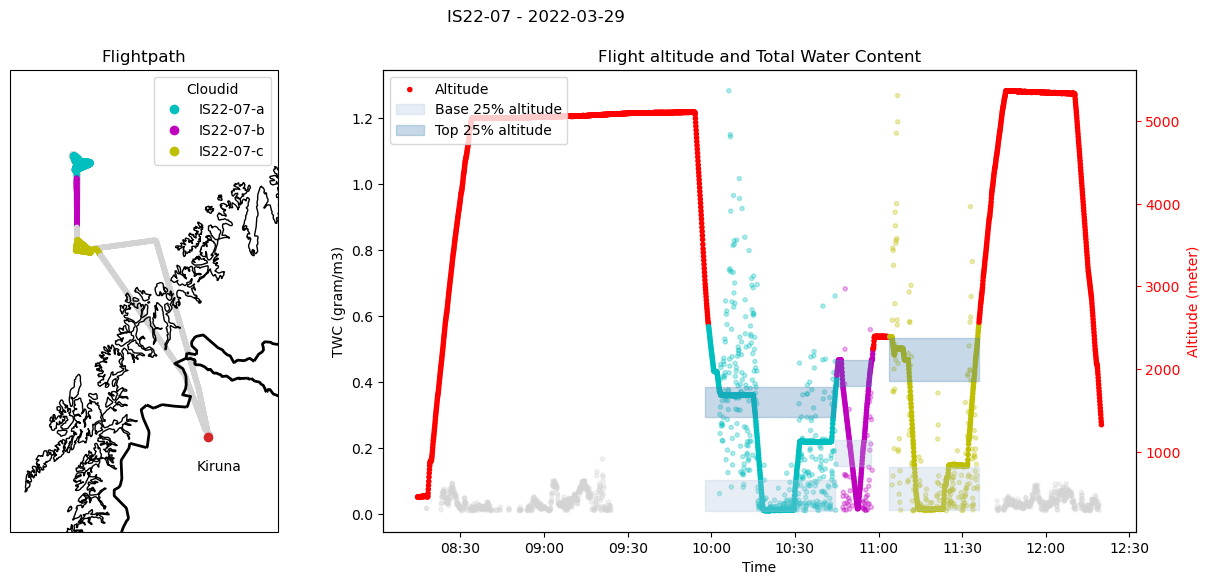

In [41]:
# ---- Plot coordinates -----
#-- Map initialization based on flight info --

# Find the max and min lat and lon in the dataset
inc = 1
lat_max = case_df['Latitude (degree)'].max() + inc
lat_min = case_df['Latitude (degree)'].min() - inc
lon_max = case_df['Longitude (degree)'].max() + inc
lon_min = case_df['Longitude (degree)'].min() - inc

# coordinates of Kiruna
lat_kir = 67.8256
lon_kir = 20.3351

# --- Set up figure
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 3, figure=fig)

ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

fig.suptitle(f'{flight} - {case_df.iloc[0]['time'].date()}') # title for all figure: flightid and date
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linewidth=2)
data_projection = ccrs.PlateCarree()

# making a dictionary for setting the colors of the cloudid automatically
c_ids = case_df['cloudid'].unique()
colors = ['lightgrey', 'c', 'm', 'y', 'g','b']
col_dict = dict(zip(c_ids, colors[:len(c_ids)]))
# update first color to use with altitude
colors[0] = 'r'
alt_col_dict = dict(zip(c_ids, colors[:len(c_ids)]))

ax.scatter(case_df['Longitude (degree)'], case_df['Latitude (degree)'], marker='.',c =case_df['cloudid'].map(col_dict), transform = data_projection)


#Plot Kiruna on map
ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection)
#Add text "Kiruna" at the plotted point
offset_lon = 0.7  # adjust the horizontal offset
offset_lat = -0.7  # adjust the vertical offset
ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.set_title('Flightpath')

ax2 = fig.add_subplot(gs[0,1:])
# plot variable
var = 'TWC (gram/m3)' # variable to show with altitude
#ax2.scatter(case_df['time'], case_df[var], marker = '.',color=np.where(case_df['Relevance']=='Lower clouds, relevant', 'black','silver'))
ax2.scatter(case_df['time'], case_df[var], marker = '.',color=case_df['cloudid'].map(col_dict), alpha=0.3)

ax2.set_ylabel(var)
ax2.set_xlabel('Time')
ax2.set_title('Flight altitude and Total Water Content')

# add second y-axis
ax3 = ax2.twinx()

# Plot altitude of flight (in color green)    
ax3.scatter(case_df['time'], case_df['Altitude (meter)'], marker = '.', color =case_df['cloudid'].map(alt_col_dict), label='Altitude')
ax3.set_ylabel('Altitude (meter)')
ax3.yaxis.label.set_color('r')
ax3.tick_params(axis='y', colors = 'r')
ax2.xaxis.set_major_formatter(formatter) # only show time on x-axis

# Mark cloud position lines 
for cloud in cloudids:
    # get x-endpoint values on axes-coordinates:
    xmin_axes, xmax_axes = functions.get_ax_vals(case_df,'cloudid',cloud, ax2)
    # Set base x-span
    ax3.axhspan(
        ymin=cloud_alt_dict[cloud]['min'],  
        ymax=cloud_alt_dict[cloud]['low_25'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='lightsteelblue',
        alpha=0.3,
        label = 'Base 25% altitude'
    )
    # Set top x-span
    ax3.axhspan(
        ymin=cloud_alt_dict[cloud]['high_25'],  
        ymax=cloud_alt_dict[cloud]['max'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='steelblue',
        alpha=0.3,
        label = 'Top 25% altitude'
    )

# handle management
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # removes duplicate labels
ax3.legend(by_label.values(), by_label.keys(), loc='upper left')

# add a legend
# pop away the first (empty) item
col_dict.pop(next(iter(col_dict)))
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in col_dict.items()]
ax.legend(title='Cloudid', handles=handles, loc='best')

plt.savefig('clouds_IS22-07.png')

In [42]:
# zooming in on the interesting parts
case_sel_df = case_df[(case_df.time >= '2022-03-29 09:55:00') & (case_df.time <= '2022-03-29 11:40:00')]


skyid: IS22-07-a
0.006961506989694416 0.45823095825410665
skyid: IS22-07-b
0.4590499590289209 0.5859950860085026
skyid: IS22-07-c
0.6457821457616745 0.9594594594355553


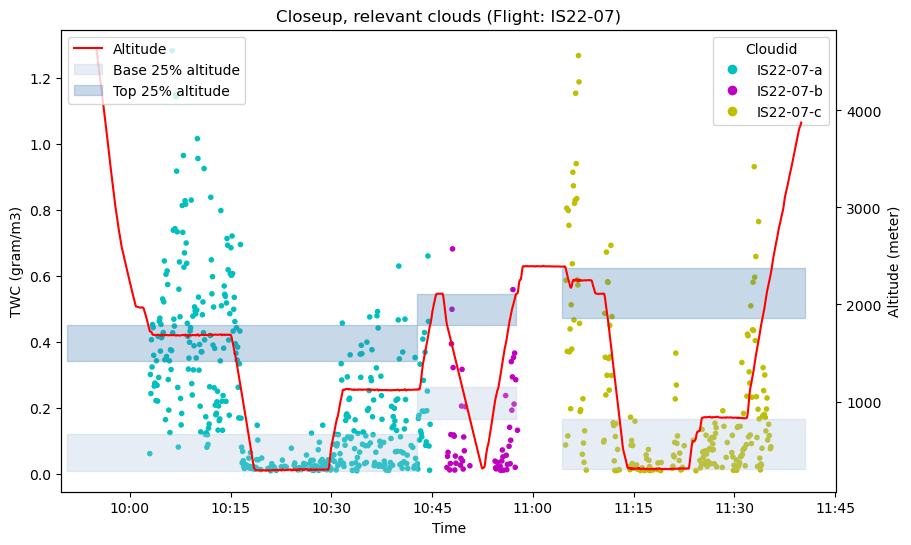

In [43]:
# --- Plotting the heights for testing
# Plotting points where the mean is calculated based on the above selection

var = 'TWC (gram/m3)' # variable to show with altitude
cloudids = case_sel_df[case_sel_df['cloudid']!='nan']['cloudid'].unique() # get unique cloudids, ignoring nan

fig, ax1 = plt.subplots(nrows = 1, ncols=1, figsize=(10,6))

# plot Total Water Content
ax1.scatter(case_sel_df['time'], case_sel_df[var], marker = '.',color =case_sel_df['cloudid'].map(alt_col_dict))
ax1.set_ylabel('TWC (gram/m3)')
ax1.set_xlabel('Time')
ax1.xaxis.set_major_formatter(formatter)
ax1.set_title(f'Closeup, relevant clouds (Flight: {flight})')

#'''
ax2 = ax1.twinx()

# Plot altitude of fligth
ax2.plot(case_sel_df['time'], case_sel_df['Altitude (meter)'], 'r', label='Altitude')
ax2.set_ylabel('Altitude (meter)')
#'''

# Mark cloud position lines 
for cloud in cloudids:
    print(f'skyid: {cloud}')
    # get x-endpoint values on axes-coordinates:
    xmin_axes, xmax_axes = functions.get_ax_vals(case_sel_df,'cloudid',cloud, ax2)
    print(xmin_axes,xmax_axes)
    # Set base x-span
    ax2.axhspan(
        ymin=cloud_alt_dict[cloud]['min'],  
        ymax=cloud_alt_dict[cloud]['low_25'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='lightsteelblue',
        alpha=0.3,
        label = 'Base 25% altitude'
    )
    # Set top x-span
    ax2.axhspan(
        ymin=cloud_alt_dict[cloud]['high_25'],  
        ymax=cloud_alt_dict[cloud]['max'],  
        xmin=xmin_axes,
        xmax=xmax_axes,
        color='steelblue',
        alpha=0.3,
        label = 'Top 25% altitude'
    )

# handle management
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) # removes duplicate labels
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

# add a legend for the clouds
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in col_dict.items()]
ax1.legend(title='Cloudid', handles=handles, loc='upper right')

#plt.savefig('as220015_pointsIncloud.png')
plt.show()

In [44]:
# testing overview plot for the different parameters

In [45]:
# selecting the times where a value changes
filter1_df = case_sel_df[case_sel_df['cloud_phase']!='Outside of cloud'][['time','Cloud_pos', 'cloudid']] #filter away times where not in cloud
my_column_changes = filter1_df['Cloud_pos'].shift() != filter1_df['Cloud_pos'] #set filter for times there cloud_pos shifts

# Extract rows where my_column_changes is False
cloudpos_in_out_df = filter1_df[my_column_changes]
cloudpos_in_out_df = cloudpos_in_out_df.reset_index(drop=True) # Reset the index 

# Find the last point a cloud is exited: (last entry where cloudid is not equal to a cloudid
last = case_sel_df[(case_sel_df['cloudid']!='nan')].iloc[-1][['time']]

cloudpos_in_out_df['endtime'] = cloudpos_in_out_df['time'] # duplicate time column
cloudpos_in_out_df['endtime'] = cloudpos_in_out_df['endtime'].shift(-1) #shift all times in endtime one row up
cloudpos_in_out_df.iloc[-1, cloudpos_in_out_df.columns.get_loc('endtime')] = last

print(cloudpos_in_out_df)


                  time Cloud_pos    cloudid             endtime
0  2022-03-29 10:02:57       Top  IS22-07-a 2022-03-29 10:15:52
1  2022-03-29 10:15:52      Bulk  IS22-07-a 2022-03-29 10:17:42
2  2022-03-29 10:17:42      Base  IS22-07-a 2022-03-29 10:30:27
3  2022-03-29 10:30:27      Bulk  IS22-07-a 2022-03-29 10:43:42
4  2022-03-29 10:43:42       Top  IS22-07-a 2022-03-29 10:47:12
5  2022-03-29 10:47:12      Bulk  IS22-07-b 2022-03-29 10:49:32
6  2022-03-29 10:49:32      Base  IS22-07-b 2022-03-29 10:55:07
7  2022-03-29 10:55:07      Bulk  IS22-07-b 2022-03-29 10:56:27
8  2022-03-29 10:56:27       Top  IS22-07-b 2022-03-29 11:11:12
9  2022-03-29 11:11:12      Bulk  IS22-07-c 2022-03-29 11:14:22
10 2022-03-29 11:14:22      Base  IS22-07-c 2022-03-29 11:25:12
11 2022-03-29 11:25:12      Bulk  IS22-07-c 2022-03-29 11:34:12
12 2022-03-29 11:34:12       Top  IS22-07-c 2022-03-29 11:35:57


## Marg plot for the full flight and for the mixed phase clouds

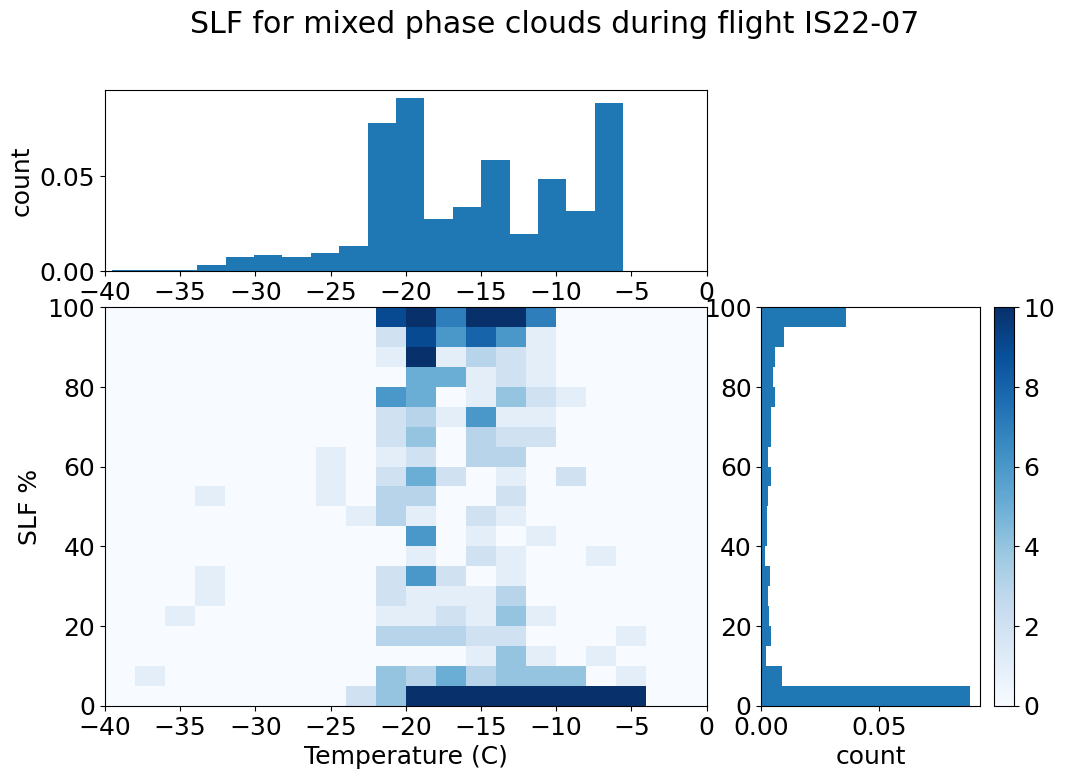

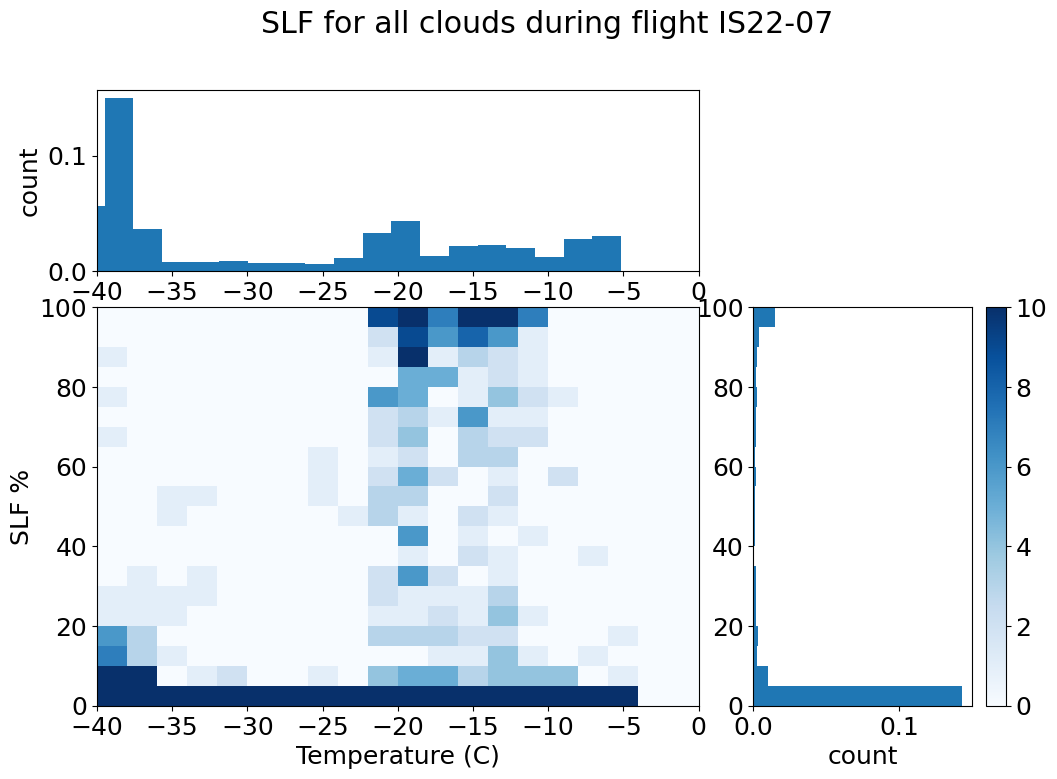

In [61]:

flight_sel_df = microphy_df[microphy_df['flightid']==flight] #the full selected flight

def slf_marg_plot(df, title, filestr = ""):
    import matplotlib.gridspec as gridspec
    
    fig = plt.figure(figsize=(12,8))

    plt.rcParams['font.size'] = 18
    
    gs = gridspec.GridSpec(3, 3)
    ax_main = plt.subplot(gs[1:3, :2])
    ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)
        
    hh = ax_main.hist2d(df['Temperature (Celsius)'], df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
    ax_main.set_ylabel('SLF %')
    ax_main.set_xlabel('Temperature (C)')
    
    
    ax_xDist.hist(df['Temperature (Celsius)'],bins=20, align='left', density = True)
    ax_xDist.set(ylabel='count')
    
    ax_yDist.hist(df['SLF'],bins=20,orientation='horizontal', density = True)
    ax_yDist.set(xlabel='count')
    fig.colorbar(hh[3], ax = ax_yDist)
    fig.suptitle(title, fontsize = 'large')
    plt.show

    if filestr != '':
        plt.savefig(filestr)
    
    return(fig)

mp_plot = slf_marg_plot(case_sel_df, f'SLF for mixed phase clouds during flight {flight}', 'mixedphaseIS2207.png')
all_plot = slf_marg_plot(flight_sel_df, f'SLF for all clouds during flight {flight}', 'allcloudsIS2207.png')

In [17]:
microphy_df.columns

Index(['time', 'Latitude (degree)', 'Longitude (degree)', 'Altitude (meter)',
       'flightid', 'safireid', 'Temperature (Celsius)', 'TAS (m/s)',
       'cip NumConc (#/m^3)', 'cdp NumConc (#/cm^3)',
       'cdp NumConc corr (#/cm^3)', 'cip IWC (g/m^3)', 'cip LWC (g/m^3)',
       'cdp LWC (g/m^3)', 'cdp LWC corr (g/m^3)', 'cip MVD (um)',
       'cdp MVD (um)', 'Relevance', 'cloudid', 'Cloud_pos', 'Cloud_rel_alt',
       'surface_cond', 'cip NumConc (#/cm^3)', 'tot NumConc (#/cm3)',
       'TWC (gram/m3)', 'incloud', 'SLF', 'cloud_phase'],
      dtype='object')

## Margplot per cloud position

In [27]:
# select out the different categories of data for plotting in different plots

# Select: cloud altitude: Top
top_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Top')]
tl_datapoints = len(top_land_df)

# Select: cloud altitude: Bulk
bulk_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Bulk')]
bkl_datapoints = len(bulk_land_df)

# Select: cloud altitude: Base
base_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Base')]
bl_datapoints = len(base_land_df)


/tmp/ipykernel_4445/3510004775.py:109: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


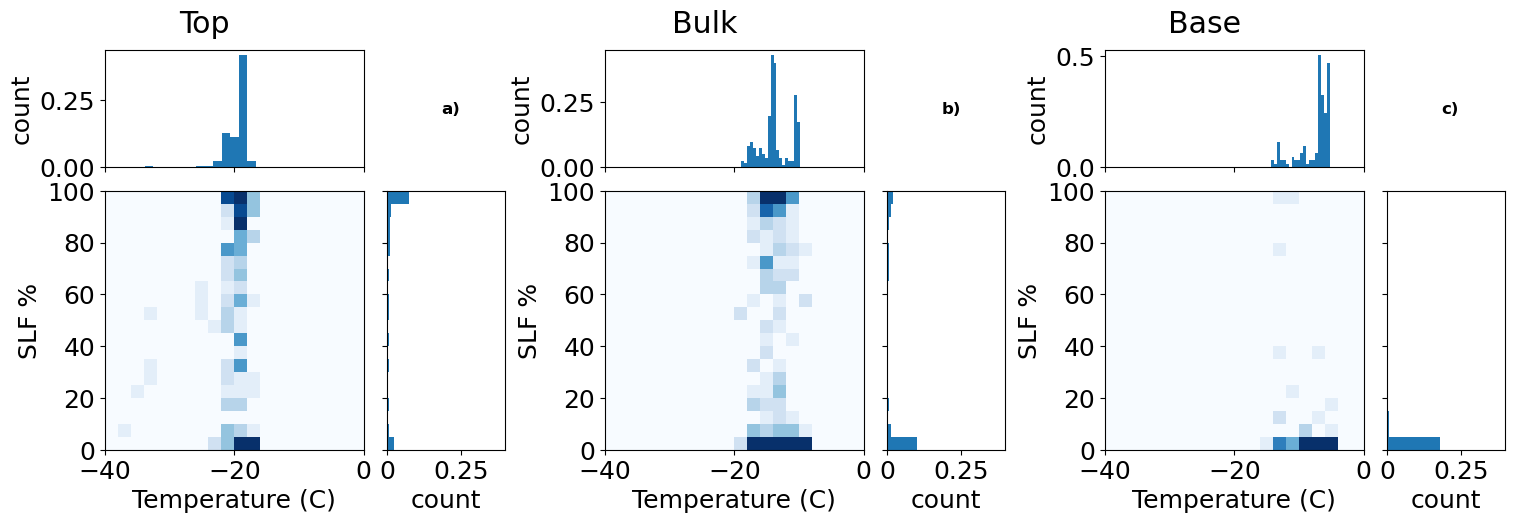

In [39]:
# Huge multifigure number concentration (surface vs place in cloud grid)

# x-axis settings for marginal plot: SLF/right plot
slf_xax =[0,0.4] # setting the x-axis manually
slf_xax_xtic = [0, 0.25]
slf_xax_lab = ['0', '0.25']


fig = plt.figure(figsize=(15,5))

# create three subfigures
(top_fig, bulk_fig, base_fig) = fig.subfigures(1, 3)


# Set titles to the subfigures
top_fig.suptitle('Top', x= 0.3)
bulk_fig.suptitle('Bulk', x= 0.3)
base_fig.suptitle('Base', x= 0.3)


# ---- Top ---
gs = GridSpec(3, 3)
ax_top_main = top_fig.add_subplot(gs[1:3, :2])
ax_top_xDist = top_fig.add_subplot(gs[0, :2],sharex=ax_top_main)
ax_top_yDist = top_fig.add_subplot(gs[1:3, 2],sharey=ax_top_main)
plots.letter_annotation(ax_top_main, 1.3, 1.3, 'a)')

ax_top_main.hist2d(top_df['Temperature (Celsius)'], top_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_top_main.set_ylabel('SLF %')
ax_top_main.set_xlabel('Temperature (C)')
    
ax_top_xDist.hist(top_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_top_xDist.set(ylabel='count')
    
ax_top_yDist.hist(top_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_top_yDist.set(xlabel='count')
ax_top_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_top_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_top_xDist.get_xticklabels(), visible=False)
plt.setp(ax_top_yDist.get_yticklabels(), visible=False)
plt.setp(ax_top_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_top_yDist.get_yticklabels(minor=True), visible=False)

# ---- Bulk Row ---
gs = GridSpec(3, 3)
ax_bulk_main = bulk_fig.add_subplot(gs[1:3, :2])
ax_bulk_xDist = bulk_fig.add_subplot(gs[0, :2],sharex=ax_top_main)
ax_bulk_yDist = bulk_fig.add_subplot(gs[1:3, 2],sharey=ax_top_main)
plots.letter_annotation(ax_bulk_main, 1.3, 1.3, 'b)')

ax_bulk_main.hist2d(bulk_df['Temperature (Celsius)'], bulk_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bulk_main.set_ylabel('SLF %')
ax_bulk_main.set_xlabel('Temperature (C)')
    
ax_bulk_xDist.hist(bulk_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bulk_xDist.set(ylabel='count')
    
ax_bulk_yDist.hist(bulk_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bulk_yDist.set(xlabel='count')
ax_bulk_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bulk_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bulk_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bulk_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bulk_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bulk_yDist.get_yticklabels(minor=True), visible=False)


# ---- Base Row ---
gs = GridSpec(3, 3)
ax_base_main = base_fig.add_subplot(gs[1:3, :2])
ax_base_xDist = base_fig.add_subplot(gs[0, :2],sharex=ax_top_main)
ax_base_yDist = base_fig.add_subplot(gs[1:3, 2],sharey=ax_top_main)
plots.letter_annotation(ax_base_main, 1.3, 1.3, 'c)')

ax_base_main.hist2d(base_df['Temperature (Celsius)'], base_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_base_main.set_ylabel('SLF %')
ax_base_main.set_xlabel('Temperature (C)')
    
ax_base_xDist.hist(base_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_base_xDist.set(ylabel='count')
ax_base_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_base_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)
    
ax_base_yDist.hist(base_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_base_yDist.set(xlabel='count')

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_base_xDist.get_xticklabels(), visible=False)
plt.setp(ax_base_yDist.get_yticklabels(), visible=False)
plt.setp(ax_base_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_base_yDist.get_yticklabels(minor=True), visible=False)

fig.tight_layout()
# fixes to not get cut of titles
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.show()
fig.savefig('mixedphase_position.png', bbox_inches='tight', pad_inches=0.1)

## Margplot per cloud position and surface type

In [16]:
# select out the different categories of data for plotting in different plots

# Select: cloud altitude: Top
top_land_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Top') & (case_sel_df['surface_cond']=='land')]
tl_datapoints = len(top_land_df)

top_sea_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Top') & (case_sel_df['surface_cond']=='sea-ocean')]
ts_datapoints = len(top_sea_df)

top_seaice_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Top') & (case_sel_df['surface_cond']=='sea-ice')]
tsi_datapoints = len(top_seaice_df)

# Select: cloud altitude: Bulk
bulk_land_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Bulk') & (case_sel_df['surface_cond']=='land')]
bkl_datapoints = len(bulk_land_df)

bulk_sea_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Bulk') & (case_sel_df['surface_cond']=='sea-ocean')]
bks_datapoints = len(bulk_sea_df)

bulk_seaice_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Bulk') & (case_sel_df['surface_cond']=='sea-ice')]
bksi_datapoints = len(bulk_seaice_df)

# Select: cloud altitude: Base
base_land_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Base') & (case_sel_df['surface_cond']=='land')]
bl_datapoints = len(base_land_df)

base_sea_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Base') & (case_sel_df['surface_cond']=='sea-ocean')]
bs_datapoints = len(base_sea_df)

base_seaice_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Base') & (case_sel_df['surface_cond']=='sea-ice')]
bsi_datapoints = len(base_seaice_df)

/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/numpy/lib/histograms.p

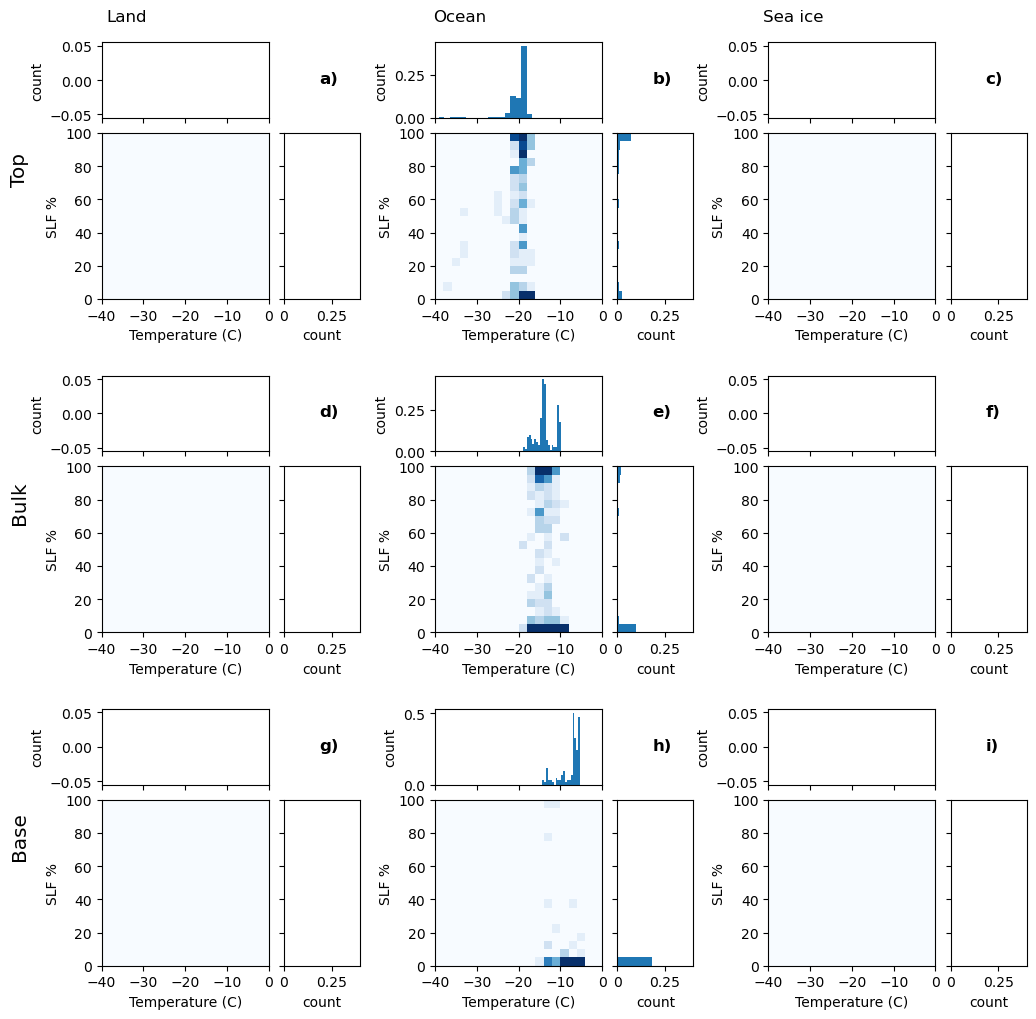

In [18]:
# Huge multifigure number concentration (surface vs place in cloud grid)

# x-axis settings for marginal plot: SLF/right plot
slf_xax =[0,0.4] # setting the x-axis manually
slf_xax_xtic = [0, 0.25]
slf_xax_lab = ['0', '0.25']


fig = plt.figure(figsize=(10,10))

# creating subfigures for the three rows/ in cloud height category
(row_top_fig, row_bulk_fig, row_base_fig) = fig.subfigures(3, 1)
#
row_top_fig.supylabel('Top', x = -0.05, y=0.5, size='x-large')
row_bulk_fig.supylabel('Bulk', x = -0.05, y=0.5, size='x-large')
row_base_fig.supylabel('Base', x = -0.05, y=0.5, size='x-large')

# splitting each row into tree subfigures
(topland_fig, topsea_fig, topice_fig) = row_top_fig.subfigures(1, 3)
(bulkland_fig, bulksea_fig, bulkice_fig) = row_bulk_fig.subfigures(1, 3)
(baseland_fig, basesea_fig, baseice_fig) = row_base_fig.subfigures(1, 3)

# Set titles to the subfigures
topland_fig.suptitle('Land', x= 0.2)
topsea_fig.suptitle('Ocean', x= 0.2)
topice_fig.suptitle('Sea ice', x= 0.2)


# ---- Top Row ---
# Top - Land
gs = GridSpec(3, 3)
ax_tl_main = topland_fig.add_subplot(gs[1:3, :2])
ax_tl_xDist = topland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_tl_yDist = topland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
plots.letter_annotation(ax_tl_main, 1.3, 1.3, 'a)')

ax_tl_main.hist2d(top_land_df['Temperature (Celsius)'], top_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_tl_main.set_ylabel('SLF %')
ax_tl_main.set_xlabel('Temperature (C)')
    
ax_tl_xDist.hist(top_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_tl_xDist.set(ylabel='count')
    
ax_tl_yDist.hist(top_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_tl_yDist.set(xlabel='count')
ax_tl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_tl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_tl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_tl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_tl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_tl_yDist.get_yticklabels(minor=True), visible=False)

# Top - Ocean
gs = GridSpec(3, 3)
ax_to_main = topsea_fig.add_subplot(gs[1:3, :2])
ax_to_xDist = topsea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_to_yDist = topsea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
plots.letter_annotation(ax_to_main, 1.3, 1.3, 'b)')

ax_to_main.hist2d(top_sea_df['Temperature (Celsius)'], top_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_to_main.set_ylabel('SLF %')
ax_to_main.set_xlabel('Temperature (C)')
    
ax_to_xDist.hist(top_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_to_xDist.set(ylabel='count')
    
ax_to_yDist.hist(top_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_to_yDist.set(xlabel='count')
ax_to_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_to_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_to_xDist.get_xticklabels(), visible=False)
plt.setp(ax_to_yDist.get_yticklabels(), visible=False)
plt.setp(ax_to_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_to_yDist.get_yticklabels(minor=True), visible=False)

# Top - Sea-ice
gs = GridSpec(3, 3)
ax_ti_main = topice_fig.add_subplot(gs[1:3, :2])
ax_ti_xDist = topice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_ti_yDist = topice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
plots.letter_annotation(ax_ti_main, 1.3, 1.3, 'c)')

ax_ti_main.hist2d(top_seaice_df['Temperature (Celsius)'], top_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_ti_main.set_ylabel('SLF %')
ax_ti_main.set_xlabel('Temperature (C)')
    
ax_ti_xDist.hist(top_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_ti_xDist.set(ylabel='count')
    
ax_ti_yDist.hist(top_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_ti_yDist.set(xlabel='count')
ax_ti_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_ti_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_ti_xDist.get_xticklabels(), visible=False)
plt.setp(ax_ti_yDist.get_yticklabels(), visible=False)
plt.setp(ax_ti_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_ti_yDist.get_yticklabels(minor=True), visible=False)

# ---- Bulk Row ---
# Bulk - Land
gs = GridSpec(3, 3)
ax_bkl_main = bulkland_fig.add_subplot(gs[1:3, :2])
ax_bkl_xDist = bulkland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_bkl_yDist = bulkland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
plots.letter_annotation(ax_bkl_main, 1.3, 1.3, 'd)')

ax_bkl_main.hist2d(bulk_land_df['Temperature (Celsius)'], bulk_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bkl_main.set_ylabel('SLF %')
ax_bkl_main.set_xlabel('Temperature (C)')
    
ax_bkl_xDist.hist(bulk_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bkl_xDist.set(ylabel='count')
    
ax_bkl_yDist.hist(bulk_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bkl_yDist.set(xlabel='count')
ax_bkl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bkl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bkl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bkl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bkl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bkl_yDist.get_yticklabels(minor=True), visible=False)

# Bulk - Ocean
gs = GridSpec(3, 3)
ax_bko_main = bulksea_fig.add_subplot(gs[1:3, :2])
ax_bko_xDist = bulksea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_bko_yDist = bulksea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
plots.letter_annotation(ax_bko_main, 1.3, 1.3, 'e)')

ax_bko_main.hist2d(bulk_sea_df['Temperature (Celsius)'], bulk_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bko_main.set_ylabel('SLF %')
ax_bko_main.set_xlabel('Temperature (C)')
    
ax_bko_xDist.hist(bulk_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bko_xDist.set(ylabel='count')
    
ax_bko_yDist.hist(bulk_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bko_yDist.set(xlabel='count')
ax_bko_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bko_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bko_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bko_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bko_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bko_yDist.get_yticklabels(minor=True), visible=False)

# Bulk - Sea-ice
gs = GridSpec(3, 3)
ax_bki_main = bulkice_fig.add_subplot(gs[1:3, :2])
ax_bki_xDist = bulkice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_bki_yDist = bulkice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
plots.letter_annotation(ax_bki_main, 1.3, 1.3, 'f)')

ax_bki_main.hist2d(bulk_seaice_df['Temperature (Celsius)'], bulk_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bki_main.set_ylabel('SLF %')
ax_bki_main.set_xlabel('Temperature (C)')
    
ax_bki_xDist.hist(bulk_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bki_xDist.set(ylabel='count')
    
ax_bki_yDist.hist(bulk_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bki_yDist.set(xlabel='count')
ax_bki_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bki_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bki_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bki_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bki_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bki_yDist.get_yticklabels(minor=True), visible=False)

# ---- Base Row ---
# Base - Land
gs = GridSpec(3, 3)
ax_bl_main = baseland_fig.add_subplot(gs[1:3, :2])
ax_bl_xDist = baseland_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_bl_yDist = baseland_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
plots.letter_annotation(ax_bl_main, 1.3, 1.3, 'g)')

ax_bl_main.hist2d(base_land_df['Temperature (Celsius)'], base_land_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bl_main.set_ylabel('SLF %')
ax_bl_main.set_xlabel('Temperature (C)')
    
ax_bl_xDist.hist(base_land_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bl_xDist.set(ylabel='count')
ax_bl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)
    
ax_bl_yDist.hist(base_land_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bl_yDist.set(xlabel='count')

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bl_yDist.get_yticklabels(minor=True), visible=False)

# base - Ocean
gs = GridSpec(3, 3)
ax_bo_main = basesea_fig.add_subplot(gs[1:3, :2])
ax_bo_xDist = basesea_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_bo_yDist = basesea_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
plots.letter_annotation(ax_bo_main, 1.3, 1.3, 'h)')

ax_bo_main.hist2d(base_sea_df['Temperature (Celsius)'], base_sea_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bo_main.set_ylabel('SLF %')
ax_bo_main.set_xlabel('Temperature (C)')
    
ax_bo_xDist.hist(base_sea_df['Temperature (Celsius)'],bins=20, align='left', density=True, stacked = True)
ax_bo_xDist.set(ylabel='count')
    
ax_bo_yDist.hist(base_sea_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bo_yDist.set(xlabel='count')
ax_bo_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bo_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bo_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bo_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bo_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bo_yDist.get_yticklabels(minor=True), visible=False)

# base - Sea-ice
gs = GridSpec(3, 3)
ax_bi_main = baseice_fig.add_subplot(gs[1:3, :2])
ax_bi_xDist = baseice_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_bi_yDist = baseice_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
plots.letter_annotation(ax_bi_main, 1.3, 1.3, 'i)')

ax_bi_main.hist2d(base_seaice_df['Temperature (Celsius)'], base_seaice_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bi_main.set_ylabel('SLF %')
ax_bi_main.set_xlabel('Temperature (C)')
    
ax_bi_xDist.hist(base_seaice_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bi_xDist.set(ylabel='count')
    
ax_bi_yDist.hist(base_seaice_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bi_yDist.set(xlabel='count')
ax_bi_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bi_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bi_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bi_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bi_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bi_yDist.get_yticklabels(minor=True), visible=False)

plt.show()

In [19]:
case_sel_df['cloudid'].unique()

array(['nan', 'IS22-07-a', 'IS22-07-b', 'IS22-07-c'], dtype=object)

In [41]:
# select out the different categories of data for plotting in different plots

# Select: cloud altitude: Top
top_a_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Top') & (case_sel_df['cloudid']=='IS22-07-a')]
ta_datapoints = len(top_a_df)

top_b_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Top') & (case_sel_df['cloudid']=='IS22-07-b')]
tb_datapoints = len(top_b_df)

top_c_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Top') & (case_sel_df['cloudid']=='IS22-07-c')]
tc_datapoints = len(top_c_df)

# Select: cloud altitude: Bulk
bulk_a_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Bulk') & (case_sel_df['cloudid']=='IS22-07-a')]
bka_datapoints = len(bulk_a_df)

bulk_b_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Bulk') & (case_sel_df['cloudid']=='IS22-07-b')]
bkb_datapoints = len(bulk_b_df)

bulk_c_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Bulk') & (case_sel_df['cloudid']=='IS22-07-c')]
bkc_datapoints = len(bulk_seaice_df)

# Select: cloud altitude: Base
base_a_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Base') & (case_sel_df['cloudid']=='IS22-07-a')]
ba_datapoints = len(base_a_df)

base_b_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Base') & (case_sel_df['cloudid']=='IS22-07-b')]
bb_datapoints = len(base_b_df)

base_c_df = case_sel_df[(case_sel_df['incloud']==True) & (case_sel_df['Cloud_pos']=='Base') & (case_sel_df['cloudid']=='IS22-07-c')]
bc_datapoints = len(base_seaice_df)

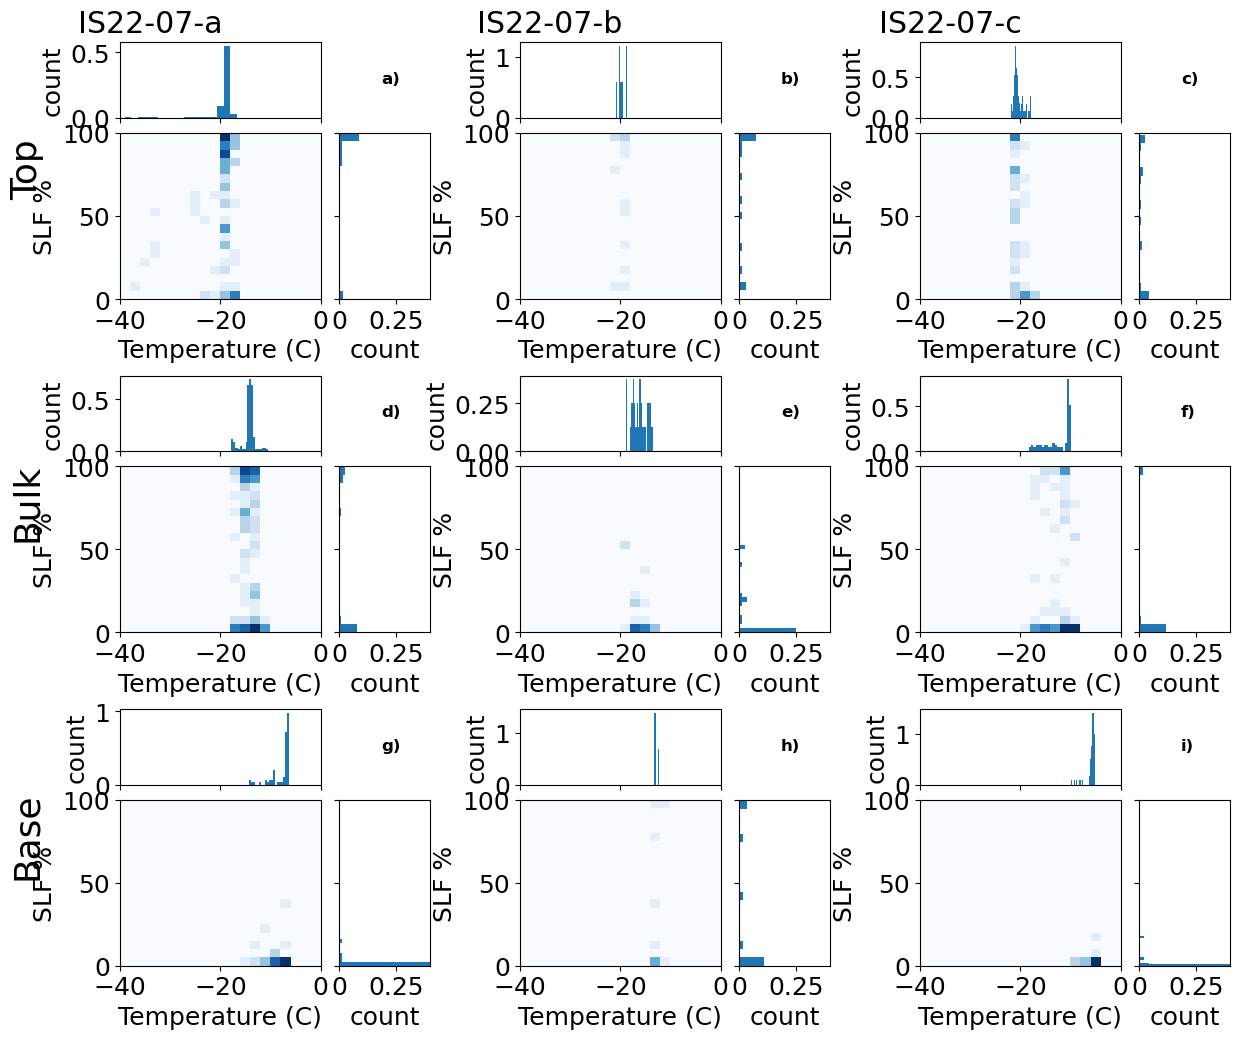

In [45]:
# Huge multifigure number concentration (surface vs place in cloud grid)

# x-axis settings for marginal plot: SLF/right plot
slf_xax =[0,0.4] # setting the x-axis manually
slf_xax_xtic = [0, 0.25]
slf_xax_lab = ['0', '0.25']


fig = plt.figure(figsize=(12,10))

# creating subfigures for the three rows/ in cloud height category
(row_top_fig, row_bulk_fig, row_base_fig) = fig.subfigures(3, 1)
#
row_top_fig.supylabel('Top', x = -0.05, y=0.5, size='x-large')
row_bulk_fig.supylabel('Bulk', x = -0.05, y=0.5, size='x-large')
row_base_fig.supylabel('Base', x = -0.05, y=0.5, size='x-large')

# splitting each row into tree subfigures
(topa_fig, topb_fig, topc_fig) = row_top_fig.subfigures(1, 3)
(bulka_fig, bulkb_fig, bulkc_fig) = row_bulk_fig.subfigures(1, 3)
(basea_fig, baseb_fig, basec_fig) = row_base_fig.subfigures(1, 3)

# Set titles to the subfigures
topa_fig.suptitle('IS22-07-a', x= 0.2)
topb_fig.suptitle('IS22-07-b', x= 0.2)
topc_fig.suptitle('IS22-07-c', x= 0.2)


# ---- Top Row ---
# Top - IS22-07-a
gs = GridSpec(3, 3)
ax_tl_main = topa_fig.add_subplot(gs[1:3, :2])
ax_tl_xDist = topa_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_tl_yDist = topa_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
plots.letter_annotation(ax_tl_main, 1.3, 1.3, 'a)')

ax_tl_main.hist2d(top_a_df['Temperature (Celsius)'], top_a_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_tl_main.set_ylabel('SLF %')
ax_tl_main.set_xlabel('Temperature (C)')
    
ax_tl_xDist.hist(top_a_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_tl_xDist.set(ylabel='count')
    
ax_tl_yDist.hist(top_a_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_tl_yDist.set(xlabel='count')
ax_tl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_tl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_tl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_tl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_tl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_tl_yDist.get_yticklabels(minor=True), visible=False)

# Top - IS22-07-b
gs = GridSpec(3, 3)
ax_to_main = topb_fig.add_subplot(gs[1:3, :2])
ax_to_xDist = topb_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_to_yDist = topb_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
plots.letter_annotation(ax_to_main, 1.3, 1.3, 'b)')

ax_to_main.hist2d(top_b_df['Temperature (Celsius)'], top_b_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_to_main.set_ylabel('SLF %')
ax_to_main.set_xlabel('Temperature (C)')
    
ax_to_xDist.hist(top_b_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_to_xDist.set(ylabel='count')
    
ax_to_yDist.hist(top_b_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_to_yDist.set(xlabel='count')
ax_to_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_to_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_to_xDist.get_xticklabels(), visible=False)
plt.setp(ax_to_yDist.get_yticklabels(), visible=False)
plt.setp(ax_to_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_to_yDist.get_yticklabels(minor=True), visible=False)

# Top - IS22-07-c
gs = GridSpec(3, 3)
ax_ti_main = topc_fig.add_subplot(gs[1:3, :2])
ax_ti_xDist = topc_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_ti_yDist = topc_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
plots.letter_annotation(ax_ti_main, 1.3, 1.3, 'c)')

ax_ti_main.hist2d(top_c_df['Temperature (Celsius)'], top_c_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_ti_main.set_ylabel('SLF %')
ax_ti_main.set_xlabel('Temperature (C)')
    
ax_ti_xDist.hist(top_c_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_ti_xDist.set(ylabel='count')
    
ax_ti_yDist.hist(top_c_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_ti_yDist.set(xlabel='count')
ax_ti_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_ti_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_ti_xDist.get_xticklabels(), visible=False)
plt.setp(ax_ti_yDist.get_yticklabels(), visible=False)
plt.setp(ax_ti_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_ti_yDist.get_yticklabels(minor=True), visible=False)

# ---- Bulk Row ---
# Bulk - IS22-07-a
gs = GridSpec(3, 3)
ax_bkl_main = bulka_fig.add_subplot(gs[1:3, :2])
ax_bkl_xDist = bulka_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_bkl_yDist = bulka_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
plots.letter_annotation(ax_bkl_main, 1.3, 1.3, 'd)')

ax_bkl_main.hist2d(bulk_a_df['Temperature (Celsius)'], bulk_a_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bkl_main.set_ylabel('SLF %')
ax_bkl_main.set_xlabel('Temperature (C)')
    
ax_bkl_xDist.hist(bulk_a_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bkl_xDist.set(ylabel='count')
    
ax_bkl_yDist.hist(bulk_a_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bkl_yDist.set(xlabel='count')
ax_bkl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bkl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bkl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bkl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bkl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bkl_yDist.get_yticklabels(minor=True), visible=False)

# Bulk - Ocean
gs = GridSpec(3, 3)
ax_bko_main = bulkb_fig.add_subplot(gs[1:3, :2])
ax_bko_xDist = bulkb_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_bko_yDist = bulkb_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
plots.letter_annotation(ax_bko_main, 1.3, 1.3, 'e)')

ax_bko_main.hist2d(bulk_b_df['Temperature (Celsius)'], bulk_b_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bko_main.set_ylabel('SLF %')
ax_bko_main.set_xlabel('Temperature (C)')
    
ax_bko_xDist.hist(bulk_b_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bko_xDist.set(ylabel='count')
    
ax_bko_yDist.hist(bulk_b_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bko_yDist.set(xlabel='count')
ax_bko_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bko_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bko_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bko_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bko_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bko_yDist.get_yticklabels(minor=True), visible=False)

# Bulk - IS22-07-c
gs = GridSpec(3, 3)
ax_bki_main = bulkc_fig.add_subplot(gs[1:3, :2])
ax_bki_xDist = bulkc_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_bki_yDist = bulkc_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
plots.letter_annotation(ax_bki_main, 1.3, 1.3, 'f)')

ax_bki_main.hist2d(bulk_c_df['Temperature (Celsius)'], bulk_c_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bki_main.set_ylabel('SLF %')
ax_bki_main.set_xlabel('Temperature (C)')
    
ax_bki_xDist.hist(bulk_c_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bki_xDist.set(ylabel='count')
    
ax_bki_yDist.hist(bulk_c_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bki_yDist.set(xlabel='count')
ax_bki_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bki_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bki_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bki_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bki_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bki_yDist.get_yticklabels(minor=True), visible=False)

# ---- Base Row ---
# Base - IS22-07-a
gs = GridSpec(3, 3)
ax_bl_main = basea_fig.add_subplot(gs[1:3, :2])
ax_bl_xDist = basea_fig.add_subplot(gs[0, :2],sharex=ax_tl_main)
ax_bl_yDist = basea_fig.add_subplot(gs[1:3, 2],sharey=ax_tl_main)
plots.letter_annotation(ax_bl_main, 1.3, 1.3, 'g)')

ax_bl_main.hist2d(base_a_df['Temperature (Celsius)'], base_a_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bl_main.set_ylabel('SLF %')
ax_bl_main.set_xlabel('Temperature (C)')
    
ax_bl_xDist.hist(base_a_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bl_xDist.set(ylabel='count')
ax_bl_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bl_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)
    
ax_bl_yDist.hist(base_a_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bl_yDist.set(xlabel='count')

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bl_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bl_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bl_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bl_yDist.get_yticklabels(minor=True), visible=False)

# base - IS22-07-b
gs = GridSpec(3, 3)
ax_bo_main = baseb_fig.add_subplot(gs[1:3, :2])
ax_bo_xDist = baseb_fig.add_subplot(gs[0, :2],sharex=ax_to_main)
ax_bo_yDist = baseb_fig.add_subplot(gs[1:3, 2],sharey=ax_to_main)
plots.letter_annotation(ax_bo_main, 1.3, 1.3, 'h)')

ax_bo_main.hist2d(base_b_df['Temperature (Celsius)'], base_b_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bo_main.set_ylabel('SLF %')
ax_bo_main.set_xlabel('Temperature (C)')
    
ax_bo_xDist.hist(base_b_df['Temperature (Celsius)'],bins=20, align='left', density=True, stacked = True)
ax_bo_xDist.set(ylabel='count')
    
ax_bo_yDist.hist(base_b_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bo_yDist.set(xlabel='count')
ax_bo_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bo_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bo_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bo_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bo_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bo_yDist.get_yticklabels(minor=True), visible=False)

# base - IS22-07-c
gs = GridSpec(3, 3)
ax_bi_main = basec_fig.add_subplot(gs[1:3, :2])
ax_bi_xDist = basec_fig.add_subplot(gs[0, :2],sharex=ax_ti_main)
ax_bi_yDist = basec_fig.add_subplot(gs[1:3, 2],sharey=ax_ti_main)
plots.letter_annotation(ax_bi_main, 1.3, 1.3, 'i)')

ax_bi_main.hist2d(base_c_df['Temperature (Celsius)'], base_c_df['SLF'], 
                 bins=(20, 20), range=[[-40,0],[0,100]],
                 cmap=plt.cm.Blues, vmin=0, vmax=10)
ax_bi_main.set_ylabel('SLF %')
ax_bi_main.set_xlabel('Temperature (C)')
    
ax_bi_xDist.hist(base_c_df['Temperature (Celsius)'],bins=20, align='left', density=True)
ax_bi_xDist.set(ylabel='count')
    
ax_bi_yDist.hist(base_c_df['SLF'],bins=20,orientation='horizontal', density=True)
ax_bi_yDist.set(xlabel='count')
ax_bi_yDist.set_xlim(slf_xax) # setting the x-axis manually
ax_bi_yDist.set_xticks(slf_xax_xtic, labels = slf_xax_lab)

# Axis labels and ticklabels for the margin plots are set to not visible
# Since they are shared with the main plot,
# removing them for the margin will also remove them from the main plot
plt.setp(ax_bi_xDist.get_xticklabels(), visible=False)
plt.setp(ax_bi_yDist.get_yticklabels(), visible=False)
plt.setp(ax_bi_xDist.get_xticklabels(minor=True), visible=False)
plt.setp(ax_bi_yDist.get_yticklabels(minor=True), visible=False)

#fig.tight_layout()
# fixes to not get cut of titles
#plt.subplots_adjust(left=0.1, right=0.1, top=0.9, bottom=0.1)
plt.savefig('SLF_per cloud.png')

plt.show()

In [22]:
# number concentration for the same fligths

# prepare cdp_bulk_df,cip_bulk_df, cdp_bins_df, cip_bins_df

# call on numbconc_hist_all from plots.
print(flight)
#cip_pb_df.columns
microphy_df.columns
cdp_bulk_df.columns


IS22-07


Index(['End Seconds', 'Day of Year', 'Year', 'Status', 'DOF Reject Counts',
       'Avg Transit Reject', 'Avg Transit Time', 'DT Bandwidth',
       'Dynamic Threshold', 'ADC Overflow', 'Laser Current (mA)',
       'Dump Spot Monitor (V)', 'Wingboard Temp (C)', 'Laser Temp (C)',
       'Sizer Baseline (V)', 'Qualifier Baseline (V)', '+5V Monitor (V)',
       'Control Board T (C)', 'Number Conc (#/cm^3)', 'LWC (g/m^3)',
       'MVD (um)', 'ED (um)', 'Applied PAS (m/s)', 'CDP Bin 1', 'CDP Bin 2',
       'CDP Bin 3', 'CDP Bin 4', 'CDP Bin 5', 'CDP Bin 6', 'CDP Bin 7',
       'CDP Bin 8', 'CDP Bin 9', 'CDP Bin 10', 'CDP Bin 11', 'CDP Bin 12',
       'CDP Bin 13', 'CDP Bin 14', 'CDP Bin 15', 'CDP Bin 16', 'CDP Bin 17',
       'CDP Bin 18', 'CDP Bin 19', 'CDP Bin 20', 'CDP Bin 21', 'CDP Bin 22',
       'CDP Bin 23', 'CDP Bin 24', 'CDP Bin 25', 'CDP Bin 26', 'CDP Bin 27',
       'CDP Bin 28', 'CDP Bin 29', 'CDP Bin 30', 'UTC Seconds', 'flightid',
       'time', 'TAS (m/s)', 'TAS probe reductio

Index(['count', 'Size (microns)', 'Min size', 'Threshold', 'Width',
       'count_norm'],
      dtype='object')


<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_52025/387184091.py:30: SyntaxWarning: invalid escape sequence '\m'
  plt.set_xlabel('Dp ($\mu$m)')
/tmp/ipykernel_52025/387184091.py:30: SyntaxWarning: invalid escape sequence '\m'
  plt.set_xlabel('Dp ($\mu$m)')


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylabel'

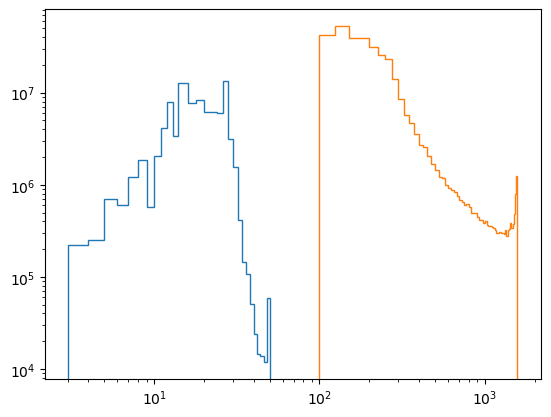

In [29]:
# hist plot for all data (from plots.py without subplots)

 


# Filter the cdp and cip dataframes for each flight
safireid = microphy_df[microphy_df['flightid']==flight]['safireid'].unique()
cdp_bulk_df = cdp_bulk_df[cdp_bulk_df['flightid']==safireid[0]]
cip_pb_df = cip_pb_df[cip_pb_df["safireid"]==safireid[0]]

# prepare the cip and cdp data for number concentration plotting
cdp_numb_conc, cip_numb_conc = numb_conc.hist_numb_conc(cdp_bulk_df, cdp_bins_df, cip_pb_df, cip_bins_df)

print(cdp_numb_conc.columns)

#fig, ax = plt.figure()
#plt.suptitle('ISLAS: CDP and CIP mean counts per bin', fontsize = 16, y=0.95)

# plot the CDP and CIP values 
plt.hist(cdp_numb_conc['Size (microns)'], weights = cdp_numb_conc['count_norm'], 
        bins=cdp_numb_conc['Size (microns)'], label = "CDP", histtype='step')
plt.hist(cip_numb_conc['Bin midpoints (microns):'], weights = cip_numb_conc['count_norm'], 
        bins=cip_numb_conc['Bin midpoints (microns):'], label = "CIP", histtype='step')

# chart formatting and anotations
plt.yscale('log')
plt.xscale('log')

plt.set_ylabel('dN/dlogDp (#/m4)')
plt.set_xlabel('Dp ($\mu$m)')
plt.legend()


In [ ]:
cip_numb_conc_mean

In [ ]:
# --- Prepare data for plotting

# Get the cip and cdp binned data ready for makeing number concentration histograms
cdp_numb_conc, cip_numb_conc = functions.prep_numb_conc(cdp_bulk_df, cdp_bins_df, cip_pb_df, cip_bins_df)
# cdp data
#cdp_bulk_df = cdp_bulk_df,
#cdp_bins_df = cdp_bins_df

# cip data
#cip_bulk_df = cip_pb_df
#cip_bins_df = cip_bins_df

# need to select out values from these based on conditions, the conditions (here: cloudid and heighttype) is used to select out a set 
# of time values. These are then used to extract the values that are within these time values

def sel_binneddata(sel_df, binned_df):
    # - Filter out values that are in the selected case from the binned data from the cip and the cdf
    # include only rows with 'time' values from these two dfs that are also in the selected case
    sel_bin_df = binned_df[binned_df['time'].isin(sel_df['time'])]
    return sel_bin_df

def cip_binneddata(sel_df, cip_pb_df):
    # the cip data is per second and the chosen + the previous 4 seconds needs to be selected
    # List to collect the rows
    result = []

    # Loop through each time in df1
    for time in sel_df['time']:
        # Find the index of the closest time in df3
        idx = (cip_pb_df['time'] - time).abs().idxmin()
        
        # Ensure we have at least 4 earlier rows
        idx_start = max(0, idx - 4)
        
        # Append these rows to the result
        result.append(cip_pb_df.iloc[idx_start:idx+1])
    
    # Concatenate all the result dataframes into one
    result_df = pd.concat(result).reset_index(drop=True)
    return result_df


test = cip_binneddata(top_a_df, cip_pb_df)
test2 = sel_binneddata(top_a_df, cip_pb_df)
test3 = cip_binneddata(top_a_df, cdp_bulk_df)
test4 = sel_binneddata(top_a_df, cdp_bulk_df)
print(test['time'].head())
print(top_a_df['time'].head())
print(test2['time'].head())
print(test3['time'].head())
print(test4['time'].head())

In [ ]:
#This script works as follows:

 #   The times from df1 are matched to the closest times in df3.
 #   For each matched time in df3, it selects that time and the 4 preceding times.
  #  The collected rows are concatenated into a single DataFrame result_df.

#Running this script will produce result_df that includes the ranges of times from df3 based on the times in df1, 
#including each time and its 4 preceding seconds.

import pandas as pd
import numpy as np

# Example DataFrames
data1 = {
    'time': ['2022-04-03 07:15:13', '2022-04-03 08:15:13', '2022-04-03 09:15:13'],
    'value': [100, 200, 300]
}
df1 = pd.DataFrame(data1)
df1['time'] = pd.to_datetime(df1['time'])

# Third DataFrame with 1 row per second
data3 = {
    'time': pd.date_range(start='2022-04-03 07:15:00', end='2022-04-03 09:15:20', freq='S'),
    'other_value': np.arange(0, (60*60*2) + 21)  # Just some example data
}
df3 = pd.DataFrame(data3)

# Convert 'time' columns to datetime objects if they are not already
df1['time'] = pd.to_datetime(df1['time'])
df3['time'] = pd.to_datetime(df3['time'])

# List to collect the rows
result = []

# Loop through each time in df1
for time in df1['time']:
    # Find the index of the closest time in df3
    idx = (df3['time'] - time).abs().idxmin()
    
    # Ensure we have at least 4 earlier rows
    idx_start = max(0, idx - 4)
    
    # Append these rows to the result
    result.append(df3.iloc[idx_start:idx+1])

# Concatenate all the result dataframes into one
result_df = pd.concat(result).reset_index(drop=True)

print(result_df)
